# Extended PM data

Try to extend PM data with new EBAS extract

In [135]:
import pyaerocom as pya
import os
import glob
import pandas as pd 
import datetime

In [158]:
# modules importation
from trends_functions import *
from warnings import filterwarnings
filterwarnings('ignore')

In [159]:
# computation parameters
params = get_params()

In [160]:
# run observations
# 'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'concpm10' 'concpm25' 'concso4' 'scatc550dryaer' 'absc550aer'
var = 'concpm10'
params['kind'] = 'obs'
fill_params(params, var)
if var in ['scatc550dryaer', 'absc550aer']:
    params['period'] = '2000-2018'
params['var'] = var
obs_source = params['source']
reader = pya.io.ReadUngridded(obs_source)
obs_data = reader.read(vars_to_retrieve=var)

In [166]:
obs_data[0].station_name

'Amberd'

### Read EBAS Files

In [335]:
#read all the .nas year from IMPROVE directory
EBAS = {}
folder = os.path.join("IMPROVE-2019_partial/data/")
for root,dirs,files in os.walk(folder):
    for file in files:
        if file.endswith(".nas"):
            f=open(folder+'/'+file, 'r')
            ebas = []
            for i, line in enumerate(f):
                #print(line.split(':')[0])
                if line.split(':')[0] == 'Station name':
                    iname = i
                if line.split(':')[0] == 'Startdate':
                    idate = i
                if line.split(':')[0].split(' ')[0] == 'starttime':
                    idata = i+1
                ebas.append(repr(line))
            
            #statname
            station_name = ebas[iname].split(':',1)[1].split('\\n')[0].strip()
            #date
            strdate0 = ebas[idate].split(':',1)[1].split('\\n')[0].strip()
            yyyy, mm, dd, hh, mn, ss = int(strdate0[0:4]), int(strdate0[4:6]), int(strdate0[6:8]), int(strdate0[8:10]), int(strdate0[10:12]), int(strdate0[12:14])
            date0 = datetime.datetime(yyyy,mm,dd,hh,mn,ss)
            #data
            data = [d[1:-3].strip().replace("''","").split(' ') for d in ebas[idata:]]
            datok = []
            #check flags
            header = ebas[idata-1][0:-3].split(' ')
            if 'flag_PM10' in header and 'flag_PM2.5' in header:
                iflagpm10 = header.index('flag_PM10')
                iflagpm25 = header.index('flag_PM2.5')
            else:
                #last columns: seame flag for both
                iflagpm10 = -1
                iflagpm25 = -1
            #data
            if 'PM10' in header:
                ipm10 = header.index('PM10')
            else:
                ipm10 = -1
            if 'PM2.5' in header:
                ipm25 = header.index('PM2.5')
            else:
                ipm25 = -1
            
            
            for dat in data:
                datok.append([float(d) for d in dat if d!=''])

            #prepare db
            thead = ['datetime','concpm10','concpm25']
            tbody = []
            for dat in datok:
                dt = date0+datetime.timedelta(days = dat[0])
                #get data
                if ipm10!=-1:
                    pm10 = dat[ipm10]
                else:
                    pm10 = np.nan
                if ipm25!=-1:
                    pm25 = dat[ipm25]
                else:
                    pm25 = np.nan
                #set flag
                if dat[iflagpm10]!=0 or pm10>=999:
                    pm10 = np.nan
                if dat[iflagpm25]!=0 or pm25>=999:
                    pm25 = np.nan
                tbody.append([dt,pm10,pm25])
            
            db = pd.DataFrame(tbody, columns=thead)
            db.set_index('datetime', inplace=True)
            db.sort_index(inplace=True)
            #resample
            db = db.resample('M').mean()
            if station_name!=EBAS.keys():
                EBAS[station_name] = db
            else:
                print('concatenate',station_name)
                EBAS[station_name] = pd.append(db)
                EBAS[station_name].sort_index(inplace=True)
            
            f.close()

(-10, 100)

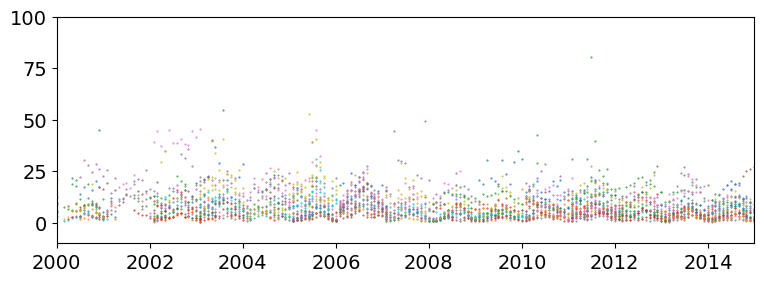

In [337]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=100, facecolor='w', edgecolor='k')
keys = list(EBAS.keys())
for key in keys:
    plt.plot(EBAS[key].index,EBAS[key].values,'.', ms=0.9)
ax.set_xlim('2000-01-01','2015-01-01')
ax.set_ylim(-10,100)


(0, 100)

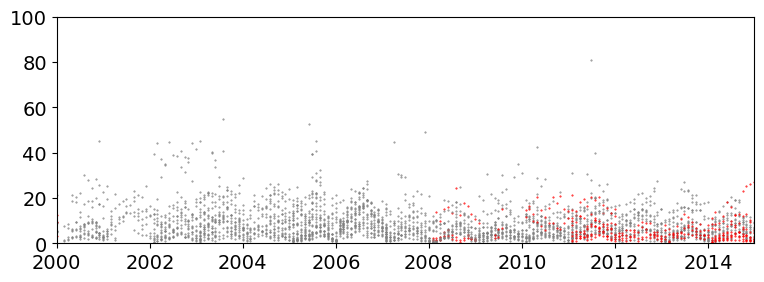

In [339]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=100, facecolor='w', edgecolor='k')
obs_names = [obs.station_name for obs in obs_data]
new_stats = []
for key in keys:
    if key not in obs_names:
        new_stats.append(key)
        plt.plot(EBAS[key].index,EBAS[key].values,'.', color="red", ms=0.9)
    else:
        plt.plot(EBAS[key].index,EBAS[key].values,'.', color="gray", ms=0.9)
ax.set_xlim('2000-01-01','2015-01-01')
ax.set_ylim(0,100)


In [330]:
new_stats

['Breton Island',
 'Rocky Mountain NP HQ',
 'Voyageurs NP #1',
 'Wrightwood',
 'Lynden',
 'Scoville',
 'Hopi Point #1',
 'Baengnyeong Island',
 'Lake Tahoe Community College',
 'Haleakala Crater',
 'South Lake Tahoe',
 'Lye Brook Wilderness (IMPROVE)',
 'Makah Tribe Site #2',
 'Pack Monadnock Summit',
 'Bondville',
 'Penobscot',
 'San Andres',
 'Barrier Lake',
 'Dome Lands Wilderness - code reserved pre 2014',
 'Londonderry',
 'Gates of the Arctic NP',
 'Owens Valley',
 'Flat Tops',
 'Stilwell (IMPROVE)',
 'Jefferson NF',
 'Sycamore Canyon 2',
 'Isle Royale NP - code reserved pre 2014',
 'Boulder Lake',
 'Kenai Peninsula Borough',
 'Steamboat Springs, Colorado (Storm Peak Laboratory)',
 'Arches NP',
 'Nogales',
 'Ripple Creek',
 'Forest County Potawatomi Community',
 'Carlsbad Caverns']

In [155]:
#statname
station_name = ebas[35].split(':',1)[1].split('\\n')[0].strip()
#date
strdate0 = ebas[23].split(':',1)[1].split('\\n')[0].strip()
yyyy, mm, dd, hh, mn, ss = int(strdate0[0:4]), int(strdate0[4:6]), int(strdate0[6:8]), int(strdate0[8:10]), int(strdate0[10:12]), int(strdate0[12:14])
date0 = datetime.datetime(yyyy,mm,dd,hh,mn,ss)
#data
data = [d[1:-3].strip().replace("''","").split(' ') for d in ebas[51:]]
datok = []
for dat in data:
    datok.append([float(d) for d in dat if d!=''])
    
#prepare db
thead = ['datetime','concpm10','concpm25']
tbody = []
for dat in datok:
    dt = date0+datetime.timedelta(hours = dat[0])
    flag = dat[-1]
    if flag==0:
        tbody.append([dt,dat[2],dat[3]])

db = pd.DataFrame(tbody, columns=thead)

EBAS[station_name] = db

In [156]:
DICT['Weminuche Wilderness']

,datetime,concpm10,concpm25
0,1996-01-03 23:17:30.001200,1.263,0.598
1,1996-01-04 06:17:30.001200,2.433,1.229
2,1996-01-04 09:17:30.001200,2.746,0.987
3,1996-01-04 13:17:30.001200,1.068,1.042
4,1996-01-04 16:17:30.001200,1.547,0.473
...,...,...,...
83,1996-01-17 19:17:30.001200,3.819,1.250
84,1996-01-17 23:17:30.001200,2.415,1.061
85,1996-01-18 02:17:30.001200,6.653,1.375
86,1996-01-18 06:17:30.001200,2.910,1.218


In [157]:
print(yyyy,mm,dd,hh,mn,ss)

1996 1 3 7 0 0


In [315]:
# computation parameters
params = get_params()

In [316]:
# computation parameters
params = get_params()# run observations
# 'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'concpm10' 'concpm25' 'concso4' 'scatc550dryaer' 'absc550aer'
var = 'concpm10'
params['kind'] = 'obs'
fill_params(params, var)
if var in ['scatc550dryaer', 'absc550aer']:
    params['period'] = '2000-2018'
params['var'] = var
obs_source = params['source']
reader = pya.io.ReadUngridded(obs_source)
obs_data = reader.read(vars_to_retrieve=var)